# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [2]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS_PCP_forecasts_Sums_CMS.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS_TMP_forecasts_Avgs_K.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS_EVAP_forecasts_Sums_CMS.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [3]:
X = pd.DataFrame({
    'su_pcp_w': pcp_data['sup_lake'],
    'er_pcp_w': pcp_data['eri_lake'],
    'on_pcp_w': pcp_data['ont_lake'],
    'mh_pcp_w': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_pcp_l': pcp_data['sup_land'],
    'er_pcp_l': pcp_data['eri_land'],
    'on_pcp_l': pcp_data['ont_land'],
    'mh_pcp_l': pcp_data['mic_land']+pcp_data['hur_land'],
    'su_evap_w': evap_data['sup_lake'],
    'er_evap_w': evap_data['eri_lake'],
    'on_evap_w': evap_data['ont_lake'],
    'mh_evap_w': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_evap_l': evap_data['sup_land'],
    'er_evap_l': evap_data['eri_land'],
    'on_evap_l': evap_data['ont_land'],
    'mh_evap_l': evap_data['mic_land']+evap_data['hur_land'],
    'su_tmp_w': tmp_data['sup_lake'],
    'er_tmp_w': tmp_data['eri_lake'],
    'on_tmp_w': tmp_data['ont_lake'],
    'mh_tmp_w': (tmp_data['mic_lake']+tmp_data['hur_lake'])/2,
    'su_tmp_l': tmp_data['sup_land'],
    'er_tmp_l': tmp_data['eri_land'],
    'on_tmp_l': tmp_data['ont_land'],
    'mh_tmp_l': (tmp_data['mic_land']+tmp_data['hur_land'])/2
})
print(X)

         su_pcp_w    er_pcp_w    on_pcp_w     mh_pcp_w     su_pcp_l  \
0      636.369837  300.622778   63.822853  2466.485814  1652.077148   
1     2744.115733  375.388680  181.523281  2534.983177  6302.072992   
2     2605.488977  540.368897  271.529871  5117.100000  5124.974193   
3     2062.170153  677.219713  298.480950  2658.118961  4207.967037   
4     1852.993242  532.976397  292.464141  2550.001095  2882.919665   
...           ...         ...         ...          ...          ...   
1852  1792.290964  373.438614  319.897592  2830.191006  2980.693249   
1853  1561.505597  559.944261  324.526475  2862.413584  3202.111480   
1854  3011.704703  370.694958  253.020255  1992.450268  6697.040221   
1855  1384.161151  314.211017  211.435008  3209.360506  3159.430715   
1856   481.099757  665.088863  329.260196  3879.337110  1702.749643   

         er_pcp_l     on_pcp_l      mh_pcp_l    su_evap_w   er_evap_w  ...  \
0     2323.615451  1118.073131   7139.162678   902.196763  591.158547

Standardize the data

In [4]:
# Standardize the data
#scaler = StandardScaler()
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [5]:
# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['su_evap', 'su_precip', 'su_runoff', 'er_evap', 'er_precip', 'er_runoff',
                                          'on_evap', 'on_precip', 'on_runoff', 'mh_evap', 'mh_precip', 'mh_runoff'])
print(df_y_pred)

          su_evap    su_precip    su_runoff      er_evap    er_precip  \
0     1606.610352  1864.804066  1083.173354  1392.019081   892.702599   
1     2530.576262  3255.507588  1010.219212  1911.494320   850.886790   
2     3321.539056  2349.940053   775.118732  1840.266042   982.174860   
3     3448.345804  1717.723307   995.758400  1463.821046   992.490001   
4     4502.707929  1423.861294   560.196876  1114.369518   660.785555   
...           ...          ...          ...          ...          ...   
1852  3508.856125  1195.939286   350.732105   541.669418   519.054796   
1853  1928.729846   886.960510   878.759547   436.164569   829.574123   
1854  1785.973790  2580.117825  1728.010011   811.378222   618.759736   
1855  1076.110971  1459.449673  1333.433653   902.801225   734.680172   
1856   726.803626  1144.215321   850.432110  1056.695271  1066.256341   

        er_runoff     on_evap   on_precip    on_runoff      mh_evap  \
0      405.563804  626.171053  494.249587   855.8691

In [6]:
df = pd.DataFrame()
df['cfs_run'] = pcp_data['cfs_run'].astype(int)
df['forecast_month'] = pcp_data['forecast_month'].astype(int)
df['forecast_year'] = pcp_data['forecast_year'].astype(int)

In [7]:
df_y = pd.merge(df, df_y_pred, left_index=True, right_index=True, how='inner')

In [8]:
df_y['su_cnbs'] = df_y['su_precip'] + df_y['su_runoff'] - df_y['su_evap']
df_y['su_cnbs']  = df_y['su_precip'] + df_y['su_runoff'] - df_y['su_evap']
df_y['su_cnbs'] = df_y['su_precip'] + df_y['su_runoff'] - df_y['su_evap']

df_y['er_cnbs'] = df_y['er_precip'] + df_y['er_runoff'] - df_y['er_evap']
df_y['er_cnbs'] = df_y['er_precip'] + df_y['er_runoff'] - df_y['er_evap']
df_y['er_cnbs'] = df_y['er_precip'] + df_y['er_runoff'] - df_y['er_evap']

df_y['on_cnbs'] = df_y['on_precip'] + df_y['on_runoff'] - df_y['on_evap']
df_y['on_cnbs'] = df_y['on_precip'] + df_y['on_runoff'] - df_y['on_evap']
df_y['on_cnbs'] = df_y['on_precip'] + df_y['on_runoff'] - df_y['on_evap']

df_y['mh_cnbs'] = df_y['mh_precip'] + df_y['mh_runoff'] - df_y['mh_evap']
df_y['mh_cnbs'] = df_y['mh_precip'] + df_y['mh_runoff'] - df_y['mh_evap']
df_y['mh_cnbs'] = df_y['mh_precip'] + df_y['mh_runoff'] - df_y['mh_evap']

print(df_y)

         cfs_run  forecast_month  forecast_year      su_evap    su_precip  \
0     2024080100               8           2024  1606.610352  1864.804066   
1     2024080100               9           2024  2530.576262  3255.507588   
2     2024080100              10           2024  3321.539056  2349.940053   
3     2024080100              11           2024  3448.345804  1717.723307   
4     2024080100              12           2024  4502.707929  1423.861294   
...          ...             ...            ...          ...          ...   
1852  2024091518               2           2025  3508.856125  1195.939286   
1853  2024091518               3           2025  1928.729846   886.960510   
1854  2024091518               4           2025  1785.973790  2580.117825   
1855  2024091518               5           2025  1076.110971  1459.449673   
1856  2024091518               6           2025   726.803626  1144.215321   

        su_runoff      er_evap    er_precip    er_runoff     on_evap  \
0  

Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

In [39]:
current_month = datetime.now().month
current_year = datetime.now().year

filtered_y_pred = df_y[
    (df_y['forecast_year'] > current_year) |
    ((df_y['forecast_year'] == current_year) & (df_y['forecast_month'] >= current_month))
]
filtered_y_pred.to_csv(dir+f'CNBS_forecasts.csv',sep=',',index=False)
months = pd.DataFrame(filtered_y_pred['forecast_month']).reset_index(drop=True)

print(months)

      forecast_month
0                  9
1                 10
2                 11
3                 12
4                  1
...              ...
1731               2
1732               3
1733               4
1734               5
1735               6

[1736 rows x 1 columns]


In [14]:
def mean_min_max(df,lake):
    mean = df.groupby(['forecast_year', 'forecast_month'])[lake].mean().reset_index()
    min = df.groupby(['forecast_year', 'forecast_month'])[lake].min().reset_index()
    max = df.groupby(['forecast_year', 'forecast_month'])[lake].max().reset_index()

    return mean, min, max

mean_su_evap, min_su_evap, max_su_evap = mean_min_max(filtered_y_pred,'su_evap')
mean_su_precip, min_su_precip, max_su_precip = mean_min_max(filtered_y_pred,'su_precip')
mean_su_runoff, min_su_runoff, max_su_runoff = mean_min_max(filtered_y_pred,'su_runoff')
mean_su_cnbs, min_su_cnbs, max_su_cnbs = mean_min_max(filtered_y_pred,'su_cnbs')

mean_er_evap, min_er_evap, max_er_evap = mean_min_max(filtered_y_pred,'er_evap')
mean_er_precip, min_er_precip, max_er_precip = mean_min_max(filtered_y_pred,'er_precip')
mean_er_runoff, min_er_runoff, max_er_runoff = mean_min_max(filtered_y_pred,'er_runoff')
mean_er_cnbs, min_er_cnbs, max_er_cnbs = mean_min_max(filtered_y_pred,'er_cnbs')

mean_on_evap, min_on_evap, max_on_evap = mean_min_max(filtered_y_pred,'on_evap')
mean_on_precip, min_on_precip, max_on_precip = mean_min_max(filtered_y_pred,'on_precip')
mean_on_runoff, min_on_runoff, max_on_runoff = mean_min_max(filtered_y_pred,'on_runoff')
mean_on_cnbs, min_on_cnbs, max_on_cnbs = mean_min_max(filtered_y_pred,'on_cnbs')

mean_mh_evap, min_mh_evap, max_mh_evap = mean_min_max(filtered_y_pred,'mh_evap')
mean_mh_precip, min_mh_precip, max_mh_precip = mean_min_max(filtered_y_pred,'mh_precip')
mean_mh_runoff, min_mh_runoff, max_mh_runoff = mean_min_max(filtered_y_pred,'mh_runoff')
mean_mh_cnbs, min_mh_cnbs, max_mh_cnbs = mean_min_max(filtered_y_pred,'mh_cnbs')

In [36]:
print(mean_mh_cnbs)

   forecast_year  forecast_month      mh_cnbs
0           2024               9  1483.351254
1           2024              10  1015.249937
2           2024              11   642.126338
3           2024              12   425.422200
4           2025               1   562.404464
5           2025               2   820.560621
6           2025               3  1580.972499
7           2025               4  2648.527150
8           2025               5  3075.506057
9           2025               6  3060.702284


In [40]:
def plot_cnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(20, 10), sharex=True)#, sharey=True)
    axs = axs.flatten()
    
    row_labels = ['Lake Superior', 'Lake Mich-Huron', 'Lake Erie', 'Lake Ontario']
    column_labels = ['Precipitation [cms]', 'Evaporation [cms]', 'Runoff [cms]', 'CNBS [cms]']

    # Initialize lists to hold y min and max values to set y limits later
    y_limits = {
        'cnbs': [float('inf'), -float('inf')],
        'other': [float('inf'), -float('inf')],
    }

    # First pass to find the global min and max for each group
    for i, (category, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        if i in [3, 7, 11, 13]:
            y_limits['cnbs'][0] = min(y_limits['cnbs'][0], min_val.min())
            y_limits['cnbs'][1] = max(y_limits['cnbs'][1], max_val.max())
        else:
            y_limits['other'][0] = min(y_limits['other'][0], min_val.min())
            y_limits['other'][1] = max(y_limits['other'][1], max_val.max())

    # Plot each dataset
    for i, (category, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        axs[i].plot(x_values, mean, color='red', linestyle='-', linewidth=1.5, label='Mean')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2)
        axs[i].set_xlim(0, 9)  # Setting x-axis limits from 1 to 10
        #axs[i].set_ylim(0, max_val.max())
        axs[i].grid(True, linestyle='--', alpha=0.6)
        
        if i in [3, 7, 11, 15]:  # Apply y-limits
            axs[i].set_ylim(y_limits['cnbs'][0]-200, y_limits['cnbs'][1]+1000)
        else:
            axs[i].set_ylim(0, y_limits['other'][1]+200)

        if i >= 12:  # Set labels for the last subplot
            axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][0]], calendar.month_abbr[months['forecast_month'][1]],
                                    calendar.month_abbr[months['forecast_month'][2]], calendar.month_abbr[months['forecast_month'][3]],
                                    calendar.month_abbr[months['forecast_month'][4]], calendar.month_abbr[months['forecast_month'][5]],
                                    calendar.month_abbr[months['forecast_month'][6]], calendar.month_abbr[months['forecast_month'][7]],
                                    calendar.month_abbr[months['forecast_month'][8]], calendar.month_abbr[months['forecast_month'][9]]])

    # Add row labels on the left side        
    for i in range(4):
            axs[i * 4].set_ylabel(row_labels[i], rotation=90, labelpad=10, fontsize=12)
    
    # Add column labels on the top
    for i in range(4):
        axs[i].set_title(column_labels[i], pad=10, fontsize=12)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(dir+f'CNBS_forecasts.png', bbox_inches='tight')
    plt.show()

0    -550.643316
1   -2164.274350
2   -2877.225366
3   -2865.643328
4   -2255.341590
5   -2207.712917
6   -2256.307691
7   -1365.042839
8     549.782574
9    1267.843804
Name: su_cnbs, dtype: float64
()
0    5047.593311
1    5460.999525
2    4184.618683
3     700.939357
4     572.551640
5     855.027477
6    3116.807128
7    4878.539358
8    4631.485738
9    4684.348251
Name: su_cnbs, dtype: float64
()
0     367.192819
1    -740.990874
2   -1032.413443
3    -747.128964
4    -343.397590
5    -171.145151
6     -23.305833
7     694.371547
8    1431.053578
9    1592.939425
Name: mh_cnbs, dtype: float64
()
0    5809.437686
1    4825.216567
2    4285.559496
3    2907.898436
4    3126.072208
5    4592.918559
6    4493.945328
7    5221.696115
8    5815.156125
9    5202.581740
Name: mh_cnbs, dtype: float64
()
0    -870.771660
1   -1219.489857
2   -1066.160370
3    -586.413870
4     -91.632399
5     -58.387952
6      -3.588420
7      58.167562
8      33.174232
9    -193.012585
Name: er_cnbs, dty

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_16784\1877506229.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][0]], calendar.month_abbr[months['forecast_month'][1]],
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_16784\1877506229.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][0]], calendar.month_abbr[months['forecast_month'][1]],
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_16784\1877506229.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][0]], calendar.month_abbr[months['forecast_month'][1]],
C:\Users\f

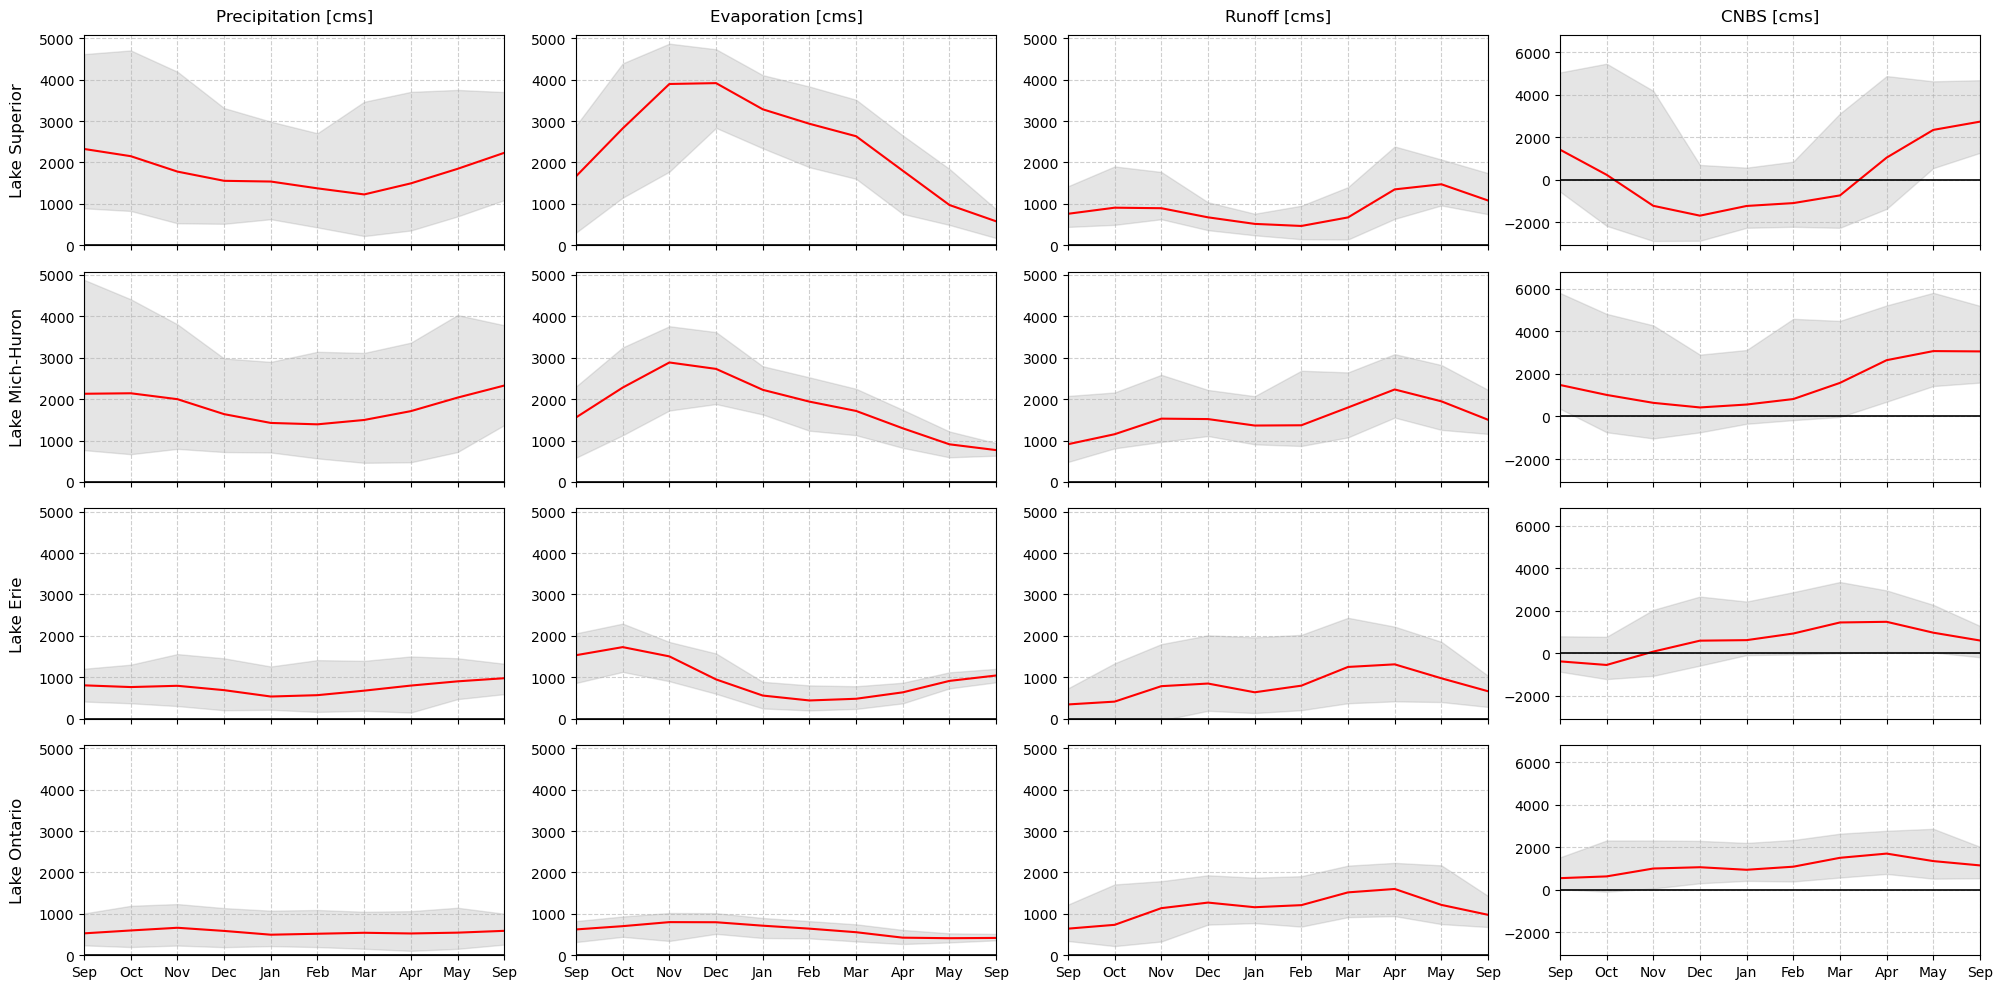

: 

In [41]:
x_values = np.arange(len(mean_su_precip['su_precip']))  # x-axis values
data_dict = {
    'Superior P': (mean_su_precip['su_precip'], min_su_precip['su_precip'], max_su_precip['su_precip']),
    'Superior E': (mean_su_evap['su_evap'], min_su_evap['su_evap'], max_su_evap['su_evap']),
    'Superior R': (mean_su_runoff['su_runoff'], min_su_runoff['su_runoff'], max_su_runoff['su_runoff']),
    'Superior CNBS': (mean_su_cnbs['su_cnbs'], min_su_cnbs['su_cnbs'], max_su_cnbs['su_cnbs']),
    'Mich-Huron P': (mean_mh_precip['mh_precip'], min_mh_precip['mh_precip'], max_mh_precip['mh_precip']),
    'Mich-Huron E': (mean_mh_evap['mh_evap'], min_mh_evap['mh_evap'], max_mh_evap['mh_evap']),
    'Mich-Huron R': (mean_mh_runoff['mh_runoff'], min_mh_runoff['mh_runoff'], max_mh_runoff['mh_runoff']),
    'Mich-Huron CNBS': (mean_mh_cnbs['mh_cnbs'], min_mh_cnbs['mh_cnbs'], max_mh_cnbs['mh_cnbs']),
    'Erie P': (mean_er_precip['er_precip'], min_er_precip['er_precip'], max_er_precip['er_precip']),
    'Erie E': (mean_er_evap['er_evap'], min_er_evap['er_evap'], max_er_evap['er_evap']),
    'Erie R': (mean_er_runoff['er_runoff'], min_er_runoff['er_runoff'], max_er_runoff['er_runoff']),
    'Erie CNBS': (mean_er_cnbs['er_cnbs'], min_er_cnbs['er_cnbs'], max_er_cnbs['er_cnbs']),
    'Ontario P': (mean_on_precip['on_precip'], min_on_precip['on_precip'], max_on_precip['on_precip']),
    'Ontario E': (mean_on_evap['on_evap'], min_on_evap['on_evap'], max_on_evap['on_evap']),
    'Ontario R': (mean_on_runoff['on_runoff'], min_on_runoff['on_runoff'], max_on_runoff['on_runoff']),
    'Ontario CNBS': (mean_on_cnbs['on_cnbs'], min_on_cnbs['on_cnbs'], max_on_cnbs['on_cnbs'])
}

plot_cnbs_forecast(x_values, data_dict)